# CUTOUTS

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20231212' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'astroget', 'NOIRLab', 'cutout', 'chip']

<a class="anchor" id="Table-of-contents"></a>
## Table of contents
* [Goals & Summary](#goals)
* [Imports and setup](#imports)
* [Install astroget](#install)
* [Discover Images](#discover)
* [Get a single cutout from an image](#cutout_single)
* [Get a batch of cutouts (blocking)](#batch_blocking)
* [Get a batch of cutouts (non-blocking)](#batch_non_blocking)

<a class="anchor" id="goals"></a>
## Goals & Summary 
This notebook demonstrates using the `astroget` package to get cutouts from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

**This runs a _Prototype BETA Release_ of the cutout service.** 

<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
from pathlib import Path
from importlib import reload
from collections import defaultdict
from datetime import datetime
import warnings
import time
import tarfile

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd
from IPython.display import Audio

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Suppress astropy warnings such as:
# WARNING: The following header keyword is invalid or follows an unrecognized ...
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install ASTROGET
Install the most recent version of the `astroget`.
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
%%time
# ! pip install astroget==0.0.4a4         # A specific version 
# ! pip install --upgrade astroget        # Latest released version
# ! pip install --pre --upgrade astroget  # Latest pre-released version

# Uncomment next line to load ASTROGET from local current version of software.
! pip install --pre --upgrade ../..

Processing /home/pothiers/sandbox/astroget
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for astroget: filename=astroget-0.0.4a7-py3-none-any.whl size=13066645 sha256=3eb07a9af3feb48badc31734b88f9e3aeacd4703d640eca5bdfaaf3f24217adb
  Stored in directory: /tmp/pip-ephem-wheel-cache-6zuomy28/wheels/db/f5/81/f8567d8b9183e27b58f39e09c64a7e76e7ddf682313fc7caf2
Successfully built astroget
  Attempting uninstall: astroget
    Found existing installation: astroget 0.0.4a6
    Uninstalling astroget-0.0.4a6:
      Successfully uninstalled astroget-0.0.4a6
CPU times: user 1.54 s, sys: 226 ms, total: 1.76 s
Wall time: 1min 3s


In [4]:
import astroget.client
from astroget.utils import tic,toc
reload(astroget.client)

<module 'astroget.client' from '/home/pothiers/sandbox/astroget/venv/lib/python3.10/site-packages/astroget/client.py'>

<a class="anchor" id="configure"></a>
## Configure ASTROGET

In [5]:
print(f'Run started: {str(datetime.now())}')
# Server used must support client.cutout() methods !!!

#server = 'https://astroarchive.noirlab.edu'     # Public server,HDUs>=408,118,252 Files>=18,731,991
server = 'https://marsnat1-pat.csdc.noirlab.edu'# Test Server,  HDUs>=26,246,808  Files>=711,608
#server = 'http://localhost:8060'                # Dev Server,    HDUs>=1,216

nbdir = Path('notebook-outfiles')
nbdir.mkdir(parents=False, exist_ok=True)
#print(f'Will write files to: {str(Path.cwd() / nbdir)}')

client = astroget.client.CsdcClient(url=server, show_curl=False)
client

Run started: 2024-01-16 15:43:59.988163


astroget_vers=0.0.4a7, api_vers=6.0, url=https://marsnat1-pat.csdc.noirlab.edu, verbose=False, show_curl=False, connect_timeout=3.05, read_timeout=300.0

<a class="anchor" id="discover"></a>
# Discover images to use for cutouts (using SIA)
Find a list of HDUs that contain pixels we want.

In [6]:
# Discover image(s) of an object using VOHDU
#obj_name = 'M65' #65,(77,96)
obj_name = 'M54'  # ingested into DEV
obj_coord = SkyCoord.from_name(obj_name)
ra = obj_coord.ra.degree
dec = obj_coord.dec.degree

# default search using Overlap (essentially Postgres "&&" range operator)
# Use very small size to approximate "obj center in HDU"
#search_size = 0.0001 # radius in degrees
search_size = 0.05

# prod_type=image
# proc_type=stack,stacked
found = client.vohdu((ra,dec), search_size,  # position=(ra,dec), size(in decimal degrees)
            instrument='decam', obs_type='object', proc_type='instcal',
            VERB=1, limit=None, verbose=False)

assert found.count > 0, 'Must have some objects to use CUTOUT'
print(f'Found {found.count} matches of object {obj_name} at position: ra,dec={(ra,dec)} using client.vohdu()')
print(f'Using Astro Archive Server at {client.rooturl}')

hdus = [[rec[k] for k in ['md5sum','hdu_idx']] for rec in found.records]
targets = [[fid, hdu, ra, dec] for (fid,hdu) in hdus]
pd.DataFrame(targets, columns=['FID', 'HDU', 'RA', 'DEC'])

Found 632 matches of object M54 at position: ra,dec=(283.763875, -30.479861) using client.vohdu()
Using Astro Archive Server at https://marsnat1-pat.csdc.noirlab.edu


,FID,HDU,RA,DEC
0,00101d402c18384d0eb66e712aecb987,34,283.763875,-30.479861
1,0026cc8a22ffeb0a6d435ee8448693fd,37,283.763875,-30.479861
2,0042935057c3be86fe0894bc3276869c,34,283.763875,-30.479861
3,00c87fc6a63f0f7cae5d35f87bff814f,34,283.763875,-30.479861
4,00dfe785f4cde3de4f3f09e1422f3249,34,283.763875,-30.479861
...,...,...,...,...
627,fb335f8ce90a723450c88d5fe4fa2481,34,283.763875,-30.479861
628,fc0533877e3dc8a9c69fba75a6029174,34,283.763875,-30.479861
629,fc75341f361cfb54035dec51e5ea18d9,34,283.763875,-30.479861
630,ffe225128b4d9ba4196c22081348bb12,36,283.763875,-30.479861


Each `Target` consists of a tuple containing: 
1. ImageId  (fid:: File ID)
1. HDU
1. RA
1. DEC

#### Using `find` instead of `vohdu` would be better
We used `client.vohdu` above instead of `client.find` because, as it is, `find` is not quite adequate for us.
With a minor improvement to `client.find`, it would be able to find target locations more precisely. Until `find` is improved, we must use the less precise vohdu method.

For `FIND` to be adequate for our needs, we need to be able to do something like:
  `client.find(outfields=[...], constraints={'hdu:ra': [target_ra, 'contains']})`

where `hdu:ra` refers to the HDU RA field (defined as a range) and `target_ra` refers to the range of RA we want in our cutout. i.e. `numrange(min_target_ra, max_target_ra)`


<a class="anchor" id="cutout_single"></a>
# Get ONE Cutout

In [7]:
target = targets[0]
fid, hduidx, ra, dec = target
print(f'We have selected target: ')
print(f'  file={fid} hdu={hduidx} ra={ra} dec={dec}')

We have selected target: 
  file=00101d402c18384d0eb66e712aecb987 hdu=34 ra=283.763875 dec=-30.479861


<a class="anchor" id="gethdu"></a>
## Get and Display one HDU

HDU size in pixels = (4094, 2046)


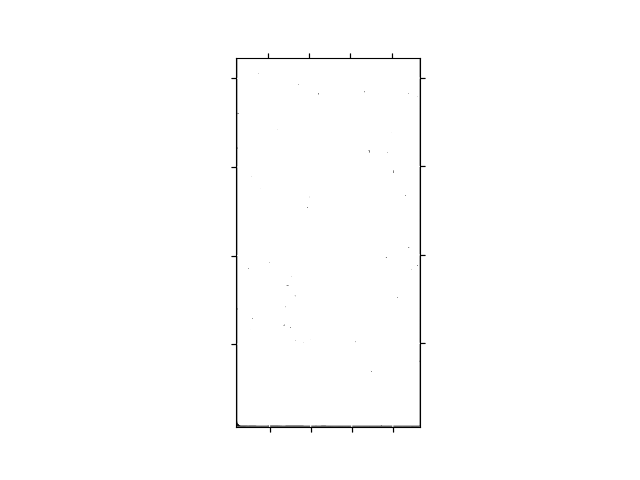

In [8]:
# Display full HDU image specified by target.
(fid,hduidx,ra,dec) = target

# Make sure archive file is valid.  Normally this will always be true, but we 
# are recovering from a "Mass Storage System" outage.
assert client.fitscheck(fid)['valid'], f"Invalid FITS file fid={fid}"

#'https://marsnat1-pat.csdc.noirlab.edu/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}
# Only get Primary and HDU containing our target.
fname = client.getimage(fid,hdus=[0,hduidx+1])
header0 = fits.getheader(fname, 0) # hdu0=Primary, hdu1=image
image_data1, header1 = fits.getdata(fname, 1, header=True) # hdu0=Primary, hdu1=image
print(f'HDU size in pixels = {image_data1.shape}')

%matplotlib widget
wcs = WCS(header1)
plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.imshow(image_data1, origin='lower', cmap='gray_r', norm='log')
plt.show()

In [9]:
help(client.cutout)

Help on method cutout in module astroget.experimental:

cutout(ra, dec, size, md5, hduidx, outfile=None, verbose=None) method of astroget.client.CsdcClient instance
    Generate and get a single cutout (FITS) from the Astro Data Archive.
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        ra (:obj:`float`): right ascension (decimal degrees) of center of target.
    
        dec (:obj:`float`): declination (decimal degrees) of center of target.
    
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        fid (:obj:`str`): File ID of FITS image in Astro Data Archive
    
        hduidx (:obj:`int`): Index of HDU in FITS file of Astro Data Archive
    
        outfile (str): Create subimage FITS file at this relative path location.
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cutouts for any targets that reference
            Prop

<a class="anchor" id="cutout_single"></a>
## Cutout and Display a single subimage

Get subimage centered at ra,dec=(283.763875, -30.479861) size 150. From image fid,hduidx=(00101d402c18384d0eb66e712aecb987, 34)
cutout url=https://marsnat1-pat.csdc.noirlab.edu/experimental/cutout/00101d402c18384d0eb66e712aecb987?ra=283.763875&dec=-30.479861&size=150&hduidx=35
subimage as been cutout into local FITS file: subimage_00101d402c18384d0eb66e712aecb987_283_-30.fits


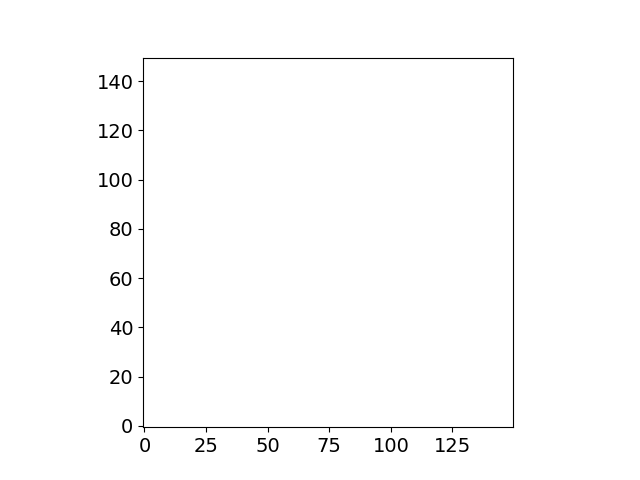

In [10]:
subimage_size = 150
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}. From image fid,hduidx=({fid}, {hduidx})')
# get FITS file
subimage = client.cutout(ra, dec, subimage_size, fid, hduidx, verbose=True)
print(f'subimage as been cutout into local FITS file: {subimage}')

image_data = fits.getdata(subimage)
plt.figure()
plt.imshow(image_data, origin='lower', cmap='gray_r')

<a class="anchor" id="batch_blocking"></a>
# Get a BATCH of cutouts (blocking)

In [11]:
print(f'Using Client context: \n{client.info}')

Using Client context: 
{'astroget_vers': '0.0.4a7', 'api_vers': 6.0, 'url': 'https://marsnat1-pat.csdc.noirlab.edu', 'verbose': False, 'show_curl': False, 'connect_timeout': 3.05, 'read_timeout': 300.0}


<a class="anchor" id="discoverBatch"></a>
## Set Targets for several cutouts 
Each Target consists of a tuple containing: 
- ImageId
- HDU
- RA
- DEC

In [12]:
help(client.cutouts)

Help on method cutouts in module astroget.experimental:

cutouts(size, target_list, tarfile='cutouts.tar', public_only=True, background=False, verbose=None) method of astroget.client.CsdcClient instance
    Retrieve a batch of cutout images from the Astro Data Archive.
    (Blocking)
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        target_list (:obj:`list`): List of 'targets'. Each 'target' consists
            of a tuple containing: fileId, hduIdx, RA_center, DEC_center
    
        tarfile (str): Create tarfile at this relative path location.
            The tarfile will contain each cutout image as a FITS file and
            MANIFEST.org file listed the files and where they came from.
            Default: 'cutouts.tar'
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cutouts fo

## Download cutouts into tarfile

In [13]:
targets[:10]

[['00101d402c18384d0eb66e712aecb987', 34, 283.763875, -30.479861],
 ['0026cc8a22ffeb0a6d435ee8448693fd', 37, 283.763875, -30.479861],
 ['0042935057c3be86fe0894bc3276869c', 34, 283.763875, -30.479861],
 ['00c87fc6a63f0f7cae5d35f87bff814f', 34, 283.763875, -30.479861],
 ['00dfe785f4cde3de4f3f09e1422f3249', 34, 283.763875, -30.479861],
 ['017ec15aff3d0f943e78c733e30ec1e3', 34, 283.763875, -30.479861],
 ['01ee7b6913880e6dcf29ea2d1ce7d9c8', 37, 283.763875, -30.479861],
 ['020181ca27d52eefa4d9eda274a40ca0', 36, 283.763875, -30.479861],
 ['0283c46d368f58d9c5f7faf18587b940', 34, 283.763875, -30.479861],
 ['0286b9b84e3fcd510e38dbc56b9f67a0', 31, 283.763875, -30.479861]]

In [14]:
tarfname0 = nbdir / 'nb-batch-0.tar.gz'
! rm {tarfname0} > /dev/null
client.cutouts(150, targets[:5], tarfile=tarfname0)

rm: cannot remove 'notebook-outfiles/nb-batch-0.tar.gz': No such file or directory


'OK'

In [15]:
runid = client.bgcutouts(51, targets[:10])
runid

'd18c5765-8277-4fd9-88e7-9f351248fc39'

In [16]:
client.cutouts_status(runid)

'PROCESSING'

In [17]:
client.cutouts_predict(runid)

{'remain_minutes': 1684515000,
 'tarfile_mb': 25300001,
 'est': {'started': '2024-01-16 22:44:13.682145',
  'now': '2024-01-16 22:44:14.692854',
  'done_time': 1.010709,
  'num_tasks_total': 10,
  'num_tasks_done': 0,
  'file_size_done': 253,
  'est_total_time': 101070900000.00002,
  'est_remain_time': 101070899998.9893,
  'est_total_file_size': 25300000000000.0,
  'est_finish': '5226-11-08T00:44:13.682'}}

In [18]:
# Look at the contents of the tarfile
# Some cutouts may not exist if there was an error in extracting them. 
with tarfile.open(tarfname0) as tf:
    tf.list(verbose=False)

MANIFEST.csv 
cutout_0.fits 
cutout_1.fits 
cutout_2.fits 
cutout_3.fits 
cutout_4.fits 


In [19]:
# Extract the MANIFEST and two cutout (FITS file)
with tarfile.open(tarfname0) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
    tf.extract('cutout_1.fits', path=nbdir)
    tf.extract('cutout_3.fits', path=nbdir)


## Look at the MANIFEST
This SHOULD show a row for every target. If there as an error extract a particular target, it should say so on the Error column and the fits file will be present.  <This feature is broken 11/15/2023>

In [20]:
pd.read_csv(nbdir / 'MANIFEST.csv')  

,Cutout,Size,ArchiveName,FileId,HDU,RA,DEC,Ok
0,cutout_0.fits,150,c4d_180430_083444_ood_g_v1.fits.fz,00101d402c18384d0eb66e712aecb987,35,283.763875,-30.479861,True
1,cutout_1.fits,150,c4d_190916_020934_oow_g_v1.fits.fz,0026cc8a22ffeb0a6d435ee8448693fd,38,283.763875,-30.479861,True
2,cutout_2.fits,150,c4d_180506_092316_ood_r_v1.fits.fz,0042935057c3be86fe0894bc3276869c,35,283.763875,-30.479861,True
3,cutout_3.fits,150,c4d_180502_085316_ooi_r_v1.fits.fz,00c87fc6a63f0f7cae5d35f87bff814f,35,283.763875,-30.479861,True
4,cutout_4.fits,150,c4d_180429_095831_ood_g_v1.fits.fz,00dfe785f4cde3de4f3f09e1422f3249,35,283.763875,-30.479861,True


## Look at a couple of cutouts

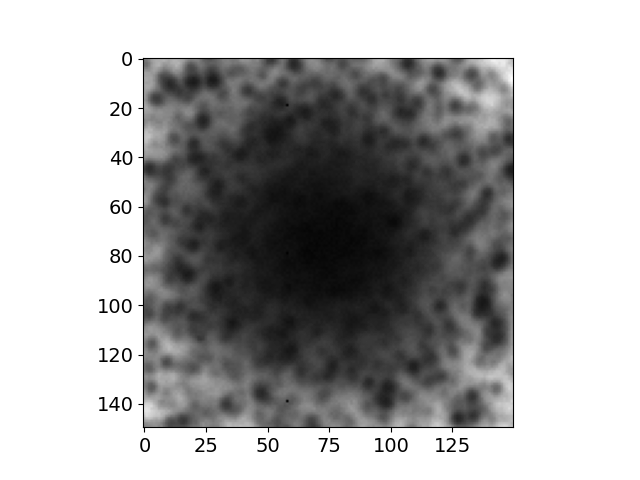

In [21]:
image_data = fits.getdata(nbdir / 'cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

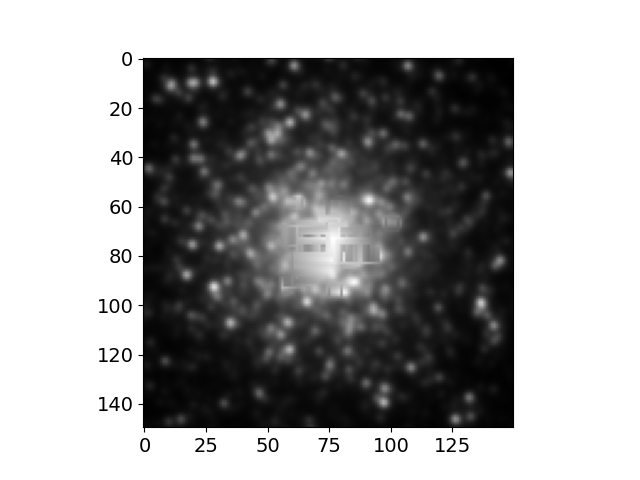

In [22]:
image_data = fits.getdata(nbdir / 'cutout_3.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

<a class="anchor" id="batch_non_blocking"></a>
# Get a BATCH of cutouts (non-blocking)
This is intended for a large batch cutouts that might take hours or days to complete. (but we will use a small batch here to keep demo time short) Since it might take a long time, we don't want our program to wait for the results. Instead, we fire off a job and will come back later to see if its done.

In [23]:
print(f'Using Client context: \n{client.info}')
tarfname1 = nbdir / 'nb-batch-1.tar.gz'
! rm {tarfname1}

Using Client context: 
{'astroget_vers': '0.0.4a7', 'api_vers': 6.0, 'url': 'https://marsnat1-pat.csdc.noirlab.edu', 'verbose': False, 'show_curl': False, 'connect_timeout': 3.05, 'read_timeout': 300.0}


In [24]:
help(client.bgcutouts)

Help on method bgcutouts in module astroget.experimental:

bgcutouts(size, target_list, tarfile='cutouts.tar.gz', public_only=True, verbose=None) method of astroget.client.CsdcClient instance
    Retrieve a batch of cutout images from the Astro Data Archive.
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        target_list (:obj:`list`): List of 'targets'. Each 'target' consists
            of a tuple containing: fileId, hduIdx, RA_center, DEC_center
    
        tarfile (str): Create tarfile at this relative path location.
            The tarfile will contain each cutout image as a FITS file and
            MANIFEST.org file listed the files and where they came from.
            Default: 'cutouts.tar'
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cutouts for any targets that referen

## Start batch run

In [25]:
print(f'Run batch of {len(targets)} targets')
runid = client.bgcutouts(150, targets[:250])
print(runid)
tic()

Run batch of 632 targets
4c16a2c8-05b4-4283-98cb-644bba520409


## How is Run doing?

In [26]:
#help(client.cutouts_status)
print(f'Threads: {pf(client.cutouts_threads(runid))}')
print(f'Status: {client.cutouts_status(runid)}')
print(f'Predictions: {pf(client.cutouts_predict(runid))}')
print(toc())

Threads: {'MainThread': {'daemon': False, 'native_id': 1208381}}
Status: PROCESSING
Predictions: {'est': {'done_time': 0.957781,
         'est_finish': '2024-01-16T22:48:16.010',
         'est_remain_time': 238.48746897605545,
         'est_total_file_size': 24003249.997599676,
         'est_total_time': 239.44524997605546,
         'file_size_done': 96013,
         'now': '2024-01-16 22:44:17.523227',
         'num_tasks_done': 1,
         'num_tasks_total': 250,
         'started': '2024-01-16 22:44:16.565446'},
 'remain_minutes': 4,
 'tarfile_mb': 25}
0.9298106809874298


## Wait for job to finish

In [ ]:
client.cutouts_wait(runid, verbose=True)

Active threads: {'MainThread': {'daemon': False, 'native_id': 1208381}}
DBG: est={'started': '2024-01-16 22:44:16.565446', 'now': '2024-01-16 22:44:21.116709', 'done_time': 4.551263, 'num_tasks_total': 250, 'num_tasks_done': 7, 'file_size_done': 685693, 'est_total_time': 162.54510714053507, 'est_remain_time': 157.99384414053506, 'est_total_file_size': 24489035.71393587, 'est_finish': '2024-01-16T22:46:59.110'}
DBG: est={'started': '2024-01-16 22:44:16.565446', 'now': '2024-01-16 22:44:21.753774', 'done_time': 5.188328, 'num_tasks_total': 250, 'num_tasks_done': 9, 'file_size_done': 881533, 'est_total_time': 144.1202222206209, 'est_remain_time': 138.93189422062088, 'est_total_file_size': 24487027.7775057, 'est_finish': '2024-01-16T22:46:40.685'}

Completed 9 of 250 tasks. Time spent 5 of 144 seconds
Active threads: {'MainThread': {'daemon': False, 'native_id': 1208381}}
Wait for 3 minutes for job to finish.


In [ ]:
Audio('electric-piano-3.wav', autoplay=True)

In [ ]:
print(toc())

In [ ]:
client.cutouts_threads(runid)

In [ ]:
client.cutouts_status(runid)

In [ ]:
time.sleep(3)  # give prediction time to gather some data
pred = client.cutouts_predict(runid)
print(pred)
delay = pred['remain_minutes'] * 60
print(f'Wait for {delay+2} seconds for job to finish.')
time.sleep(delay+2)

In [ ]:
print(client.cutouts_status(runid))

In [ ]:
client.cutouts_predict(runid, verbose=True)

## Get a tarfile containing the results

In [ ]:
runid

In [ ]:
client.cutouts_status(runid)

In [ ]:
client.cutouts_threads(runid)

In [ ]:
#client.show_curl=True
client.cutouts_get(runid, tarfile=tarfname1)

In [ ]:
# Extract the MANIFEST
with tarfile.open(tarfname1) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
    tf.extract('cutout_1.fits', path=nbdir)
df = pd.read_csv(nbdir / 'MANIFEST.csv')  
df

In [ ]:
print(f'Percent failed cutouts: {round(100*df.Ok.value_counts()[False]/df.shape[0])}%')

In [ ]:
image_data = fits.getdata(nbdir / 'cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

# All Done

In [ ]:
import datetime
print(f'Finished: {datetime.datetime.now()}')

In [ ]:
print("Stopping execution to avoid long running functions. "
      " Continue manually if you want."
      " Typically via jupyter notebook menu: 'Run/Run Selected Cell and All Below'")
raise StopExecution

# Random targets (using FIND)
This is just to get a large number of targets so we have a bigger batch job.

In [ ]:
found2 = client.find(
    outfields=["md5sum", "hdu:hdu_idx", "hdu:ra_center", "hdu:dec_center"],
    constraints={"hdu:ra_center":[-900, +900],
                 "hdu:dec_center":[-900, +900], 
                 "archive_filename": [".fits", "contains"]
                },
    filerec=False,
    limit=9000,
    count=False)
# "updated": ["2024-01-10","2024-01-12"],

In [ ]:
print(f'Found {found2.count} records')
targets2 = found2.records
tfields = ['md5sum','hdu:hdu_idx','hdu:ra_center','hdu:dec_center']
hdus2 = [[rec[k] for k in tfields] for rec in found2.records]
targets2 = [[fid, hdu, ra, dec] for (fid,hdu,ra,dec) in hdus2]
pd.DataFrame(targets2, columns=['FID', 'HDU', 'RA', 'DEC'])

In [ ]:
tarfname2 = nbdir / 'nb-batch-2.tar.gz'
! rm {tarfname2} > /dev/null

tic()
#res = client.cutouts(50, targets2, tarfile=tarfname2)
runid = client.bgcutouts(51, targets2[:2000])
runid

In [ ]:
client.cutouts_wait(runid, verbose=True)

In [ ]:
client.cutouts_status(runid)

In [ ]:
client.cutouts_get(runid, tarfile=tarfname2)
toc()

In [ ]:
with tarfile.open(tarfname2) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
df = pd.read_csv(nbdir / 'MANIFEST.csv')  
df

In [ ]:
print(f'Percent failed cutouts: {round(100*df.Ok.value_counts()[False]/df.shape[0])}%')